In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Imports


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

import xgboost as xgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import time

## Load dataset and create dataframes


In [3]:
# Load datasets
train_df = pd.read_csv("../datasets/layer-12/train.csv")
valid_df = pd.read_csv("../datasets/layer-12/valid.csv")
test_df = pd.read_csv("../datasets/layer-12/test.csv")

In [4]:
train_df.shape, valid_df.shape, test_df.shape

((28520, 772), (750, 772), (744, 769))

## For each label, seperate feature data


In [5]:
labels = ["label_1", "label_2", "label_3", "label_4"]

In [6]:
X_train = {}
X_valid = {}
X_test = {}
y_train = {}
y_valid = {}

In [49]:
for label in labels:
    # Standardize the feature columns
    scaler = StandardScaler()
    tr_df = train_df
    val_df = valid_df
    tst_df = test_df
    if label == "label_2":  # Remove NaN rows for label_2
        tr_df = train_df[train_df[label].notna()]
        val_df = valid_df[valid_df[label].notna()]

    X_train[label] = pd.DataFrame(scaler.fit_transform(tr_df.iloc[:, :-4]))
    X_valid[label] = pd.DataFrame(scaler.transform(val_df.iloc[:, :-4]))
    X_test[label] = pd.DataFrame(scaler.transform(tst_df.iloc[:, 1:]))

    # Ensure you keep the target labels as separate DataFrames
    y_train[label] = tr_df[label]
    y_valid[label] = val_df[label]

## Feature Selection


In [8]:
X_train_selected = {}
X_valid_selected = {}
X_test_selected = {}

Feature selection for each label


In [9]:
def feature_selection(L):
    # Figure label frequencies
    plt.figure(figsize=(15, 6))
    sn.countplot(data=y_train, x=L, color="green")

    k = (
        350
        if L == labels[0]
        else (350 if L == labels[1] else 350 if L == labels[3] else 350)
    )

    selector = SelectKBest(f_classif, k=k)

    X_train_selected[L] = pd.DataFrame(
        selector.fit_transform(X_train[label], y_train[label])
    )
    X_valid_selected[L] = pd.DataFrame(selector.transform(X_valid[label]))
    X_test_selected[L] = pd.DataFrame(selector.transform(X_test[label]))

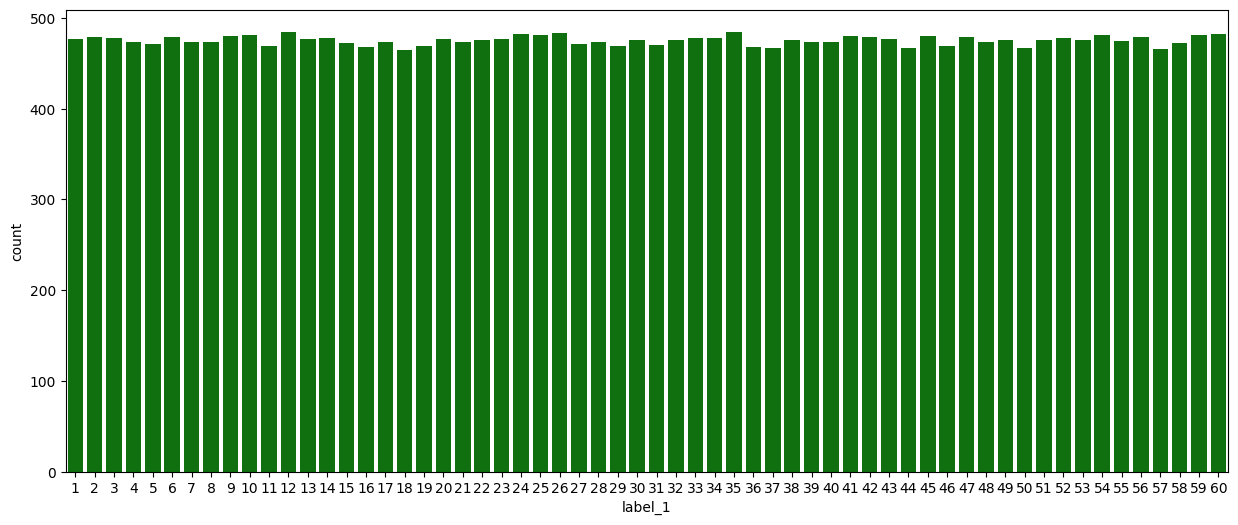

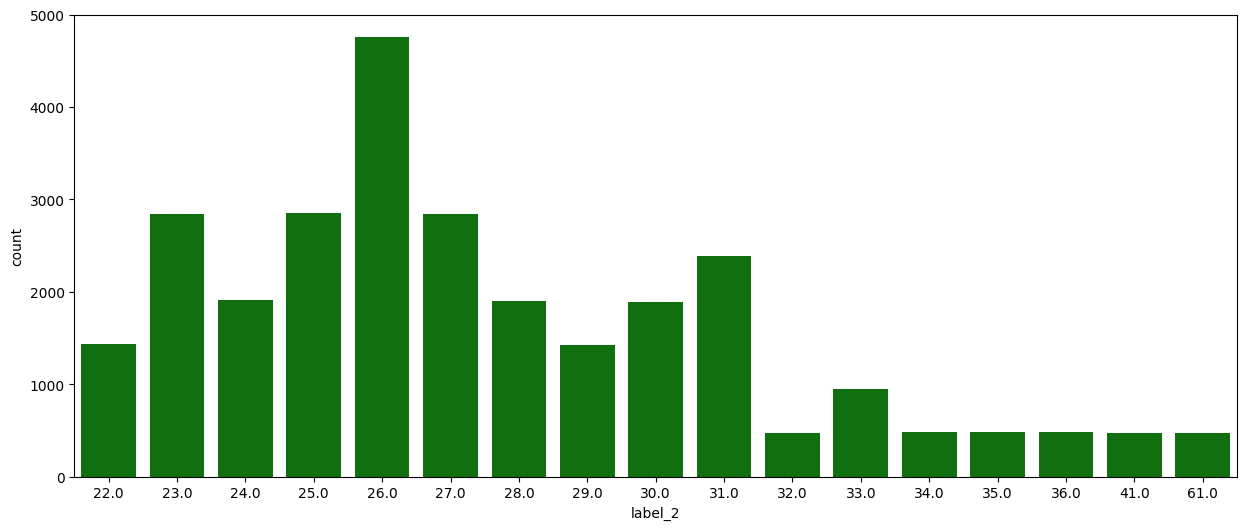

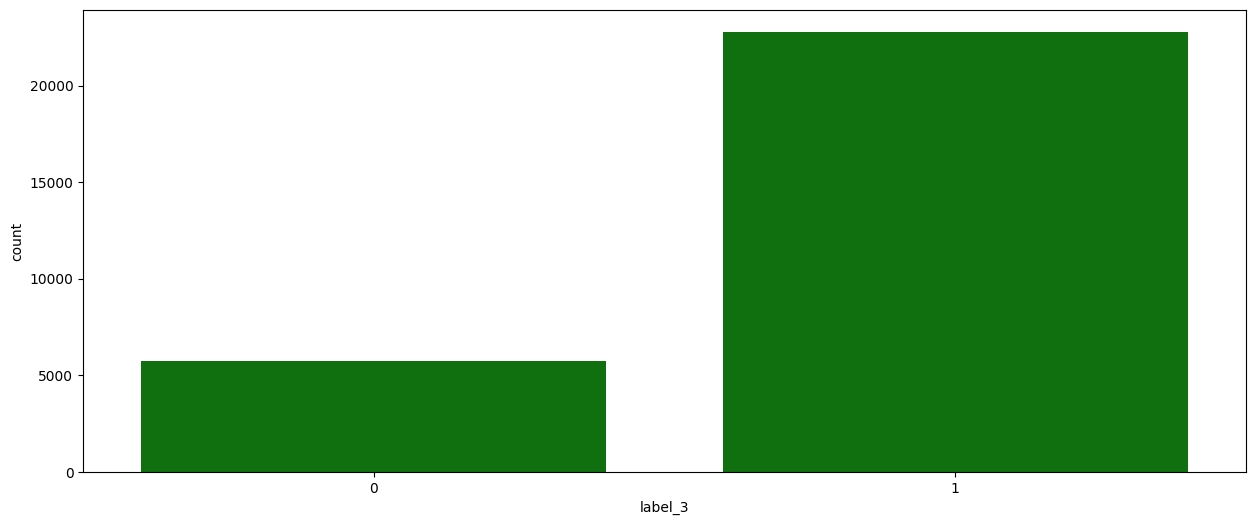

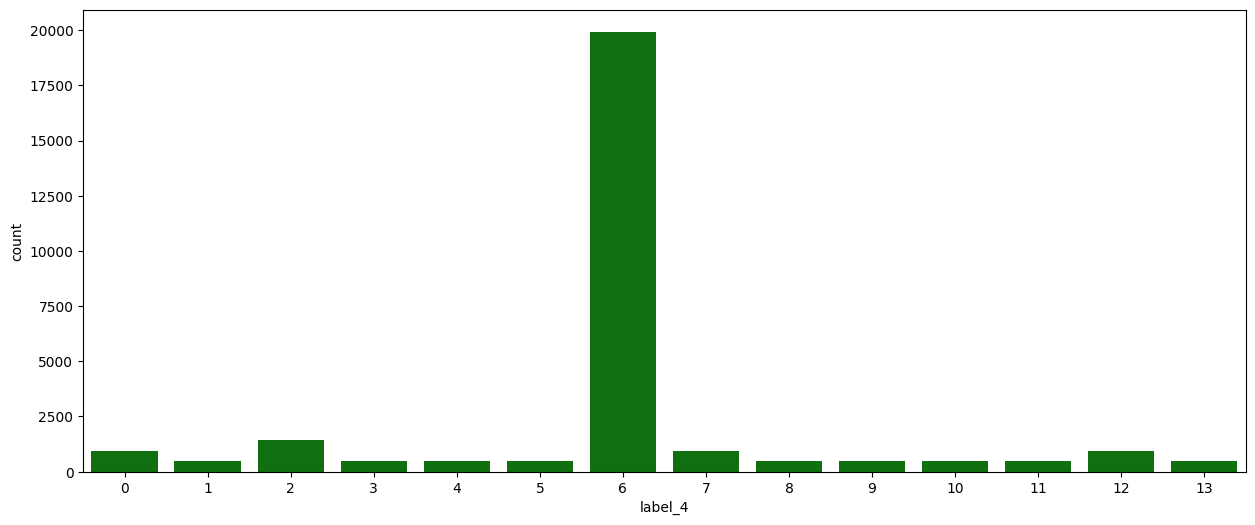

In [10]:
for label in labels:
    feature_selection(label)

In [11]:
X_train_selected["label_1"].shape

(28520, 350)

In [12]:
X_valid_selected["label_1"].shape

(750, 350)

In [13]:
X_test_selected["label_3"].shape

(744, 350)

## Dimensionality reduction using PCA


In [12]:
X_train_pca = {}
X_valid_pca = {}
X_test_pca = {}

In [13]:
from sklearn.decomposition import PCA


def PCA_reduction(L, X_train, X_valid):
    n_components = 0.99 if L == labels[1] else 0.95

    # Fit PCA on the training data
    pca = PCA(n_components=n_components)
    X_train_pca[L] = pca.fit_transform(X_train[L])

    # Transform validation and test data using the same PCA
    X_valid_pca[L] = pca.transform(X_valid[L])
    X_test_pca[L] = pca.transform(X_test[L])

In [14]:
for label in labels:
    PCA_reduction(label, X_train, X_valid)

In [15]:
X_train_pca["label_2"].shape

(28040, 385)

## Classifier Models


In [16]:
models = ["svm", "xgb", "catboost"]

In [59]:
def classifier(model, L, X_train, X_valid, y_train, y_valid):
    classifier = None
    class_weight = None if L == labels[0] else "balanced"

    if model == models[0]:
        # Create an SVM classifier
        classifier = SVC(kernel="linear", class_weight=class_weight)
    elif model == models[1]:
        # Create an XGBoost classifier
        classifier = xgb.XGBClassifier()
        # Encode the target variable if needed
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        y_train[L] = y_train[L] - 1
    elif model == models[2]:
        # Create an random forest classifier
        classifier = CatBoostClassifier()

    classifier.fit(X_train[L], y_train[L])

    y_pred = classifier.predict(X_valid[L])
    accuracy = accuracy_score(y_valid[L], y_pred)
    print(f"{model} Accuracy Score for {L} = ", accuracy)

    return classifier

## Cross validation


In [85]:
def cross_validation(model, L, X, y, catboostIterations=10):
    classifier = None
    class_weight = None if L == labels[0] else "balanced"

    if model == models[0]:
        # Create an SVM classifier
        classifier = SVC(kernel="rbf", class_weight=class_weight)
    elif model == models[1]:
        # Create an XGBoost classifier
        classifier = xgb.XGBClassifier()
        # Encode the target variable if needed
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
    elif model == models[2]:
        # Create an random forest classifier
        classifier = CatBoostClassifier(iterations=catboostIterations)

    # Perform 5-fold cross-validation
    print(f"5-fold cross validation started for {model}")
    scores = cross_val_score(classifier, X, y, cv=5)
    print(f"5-fold cross validation finished")

    # Print the cross-validation scores
    print("Cross-Validation Scores:", scores)

    # Calculate and print the mean and standard deviation of the scores
    mean_score = np.mean(scores)
    std_deviation = np.std(scores)
    print("Mean Score:", mean_score)
    print("Standard Deviation:", std_deviation)

Cross Validation for SVM


In [86]:
for label in labels:
    cross_validation(models[0], label, X_train[label], y_train[label])
    print("\n")

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.89446003 0.90007013 0.89603787 0.89042777 0.89446003]
Mean Score: 0.8950911640953716
Standard Deviation: 0.0031058081890292483


5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.33452211 0.49072753 0.5160485  0.54868046 0.40674037]
Mean Score: 0.4593437945791726
Standard Deviation: 0.07813958639353175


5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.96861851 0.9921108  0.98790323 0.97966339 0.99281206]
Mean Score: 0.9842215988779804
Standard Deviation: 0.009097509808039111


5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.76612903 0.73141655 0.71195652 0.72159888 0.70669705]
Mean Score: 0.7275596072931275
Standard Deviation: 0.0210556843681602




SVM Cross Validation Results:

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.9200561 0.9154979 0.91304348 0.91619916 0.91374474]
Mean Score: 0.9157082748948107
Standard Deviation: 0.0024554195511937785

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.37642653 0.55313837 0.603602 0.57703281 0.43099144]
Mean Score: 0.5082382310984308
Standard Deviation: 0.08852610353781822

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.97124825 0.98807854 0.98229313 0.98176718 0.99140954]
Mean Score: 0.9829593267882186
Standard Deviation: 0.006879343572650934

5-fold cross validation started for svm
5-fold cross validation finished
Cross-Validation Scores: [0.86079944 0.83888499 0.81854839 0.84940393 0.80908135]
Mean Score: 0.8353436185133241
Standard Deviation: 0.019131226513951945


Cross Validation for Catboost with 10 iterations


In [24]:
for label in labels:
    cross_validation(models[2], label, X_train[label], y_train[label], 10)
    print("\n")

5-fold cross validation started for catboost
Learning rate set to 0.5
0:	learn: 3.8043879	total: 9.07s	remaining: 1m 21s
1:	learn: 3.6084333	total: 18.1s	remaining: 1m 12s
2:	learn: 3.4213025	total: 28.9s	remaining: 1m 7s
3:	learn: 3.2391301	total: 40.4s	remaining: 1m
4:	learn: 3.0395184	total: 52s	remaining: 52s
5:	learn: 2.8809753	total: 1m 3s	remaining: 42.4s
6:	learn: 2.7426415	total: 1m 16s	remaining: 32.7s
7:	learn: 2.6103602	total: 1m 38s	remaining: 24.6s
8:	learn: 2.5100122	total: 2m 1s	remaining: 13.6s
9:	learn: 2.4118105	total: 2m 23s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3.8426541	total: 10.2s	remaining: 1m 32s
1:	learn: 3.6003102	total: 23.7s	remaining: 1m 34s
2:	learn: 3.4311802	total: 35.3s	remaining: 1m 22s
3:	learn: 3.2195041	total: 47.1s	remaining: 1m 10s
4:	learn: 3.0337964	total: 1m 3s	remaining: 1m 3s
5:	learn: 2.8921466	total: 1m 27s	remaining: 58.6s
6:	learn: 2.7442183	total: 1m 49s	remaining: 47s
7:	learn: 2.6155348	total: 2m 3s	remaining: 31s
8:	lear

In [63]:
# With 1000 ietrations for label 3
cross_validation(models[2], labels[2], X_train[labels[2]], y_train[labels[2]], 1000)

5-fold cross validation started for catboost
Learning rate set to 0.039165
0:	learn: 0.6581595	total: 107ms	remaining: 1m 46s
1:	learn: 0.6280928	total: 210ms	remaining: 1m 44s
2:	learn: 0.6010622	total: 316ms	remaining: 1m 44s
3:	learn: 0.5769416	total: 428ms	remaining: 1m 46s
4:	learn: 0.5525076	total: 547ms	remaining: 1m 48s
5:	learn: 0.5319956	total: 654ms	remaining: 1m 48s
6:	learn: 0.5123843	total: 772ms	remaining: 1m 49s
7:	learn: 0.4966278	total: 876ms	remaining: 1m 48s
8:	learn: 0.4804565	total: 980ms	remaining: 1m 47s
9:	learn: 0.4635269	total: 1.09s	remaining: 1m 47s
10:	learn: 0.4471430	total: 1.21s	remaining: 1m 48s
11:	learn: 0.4339867	total: 1.31s	remaining: 1m 47s
12:	learn: 0.4218342	total: 1.41s	remaining: 1m 46s
13:	learn: 0.4098673	total: 1.51s	remaining: 1m 46s
14:	learn: 0.3996102	total: 1.62s	remaining: 1m 46s
15:	learn: 0.3873051	total: 1.74s	remaining: 1m 47s
16:	learn: 0.3774750	total: 1.87s	remaining: 1m 48s
17:	learn: 0.3684153	total: 1.99s	remaining: 1m 48s

In [65]:
# With 100 ietrations for label 2
cross_validation(models[2], labels[1], X_train[labels[1]], y_train[labels[1]], 100)

5-fold cross validation started for catboost
Learning rate set to 0.5
0:	learn: 2.5341754	total: 2.76s	remaining: 4m 33s
1:	learn: 2.4024664	total: 6.56s	remaining: 5m 21s
2:	learn: 2.3309098	total: 11.1s	remaining: 6m
3:	learn: 2.2499166	total: 15.6s	remaining: 6m 14s
4:	learn: 2.1759235	total: 20.1s	remaining: 6m 21s
5:	learn: 2.1042988	total: 24.5s	remaining: 6m 23s
6:	learn: 2.0507187	total: 29.2s	remaining: 6m 27s
7:	learn: 1.9995200	total: 33.9s	remaining: 6m 29s
8:	learn: 1.9371589	total: 38.4s	remaining: 6m 28s
9:	learn: 1.8974009	total: 43s	remaining: 6m 26s
10:	learn: 1.8482019	total: 47.3s	remaining: 6m 22s
11:	learn: 1.8097903	total: 51.6s	remaining: 6m 18s
12:	learn: 1.7760437	total: 56s	remaining: 6m 14s
13:	learn: 1.7396152	total: 1m	remaining: 6m 12s
14:	learn: 1.7031465	total: 1m 5s	remaining: 6m 11s
15:	learn: 1.6573938	total: 1m 12s	remaining: 6m 20s
16:	learn: 1.6269812	total: 1m 18s	remaining: 6m 22s
17:	learn: 1.5946959	total: 1m 23s	remaining: 6m 20s
18:	learn: 1

Exception ignored in: <function DataIter.__del__ at 0x0000023D54D405E0>
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\xgboost\core.py", line 578, in __del__
    assert self._temporary_data is None
AssertionError: 


Learning rate set to 0.5
0:	learn: 2.5428755	total: 5.39s	remaining: 8m 53s
1:	learn: 2.4173947	total: 13.1s	remaining: 10m 40s
2:	learn: 2.3315477	total: 22.8s	remaining: 12m 18s
3:	learn: 2.2514304	total: 29.5s	remaining: 11m 46s
4:	learn: 2.1877198	total: 34.3s	remaining: 10m 52s
5:	learn: 2.1188500	total: 39.1s	remaining: 10m 13s
6:	learn: 2.0702168	total: 43.8s	remaining: 9m 42s
7:	learn: 2.0013193	total: 48.5s	remaining: 9m 18s
8:	learn: 1.9498555	total: 54.5s	remaining: 9m 10s
9:	learn: 1.8987240	total: 59.4s	remaining: 8m 54s
10:	learn: 1.8585972	total: 1m 4s	remaining: 8m 38s
11:	learn: 1.8287170	total: 1m 9s	remaining: 8m 27s
12:	learn: 1.7866730	total: 1m 15s	remaining: 8m 23s
13:	learn: 1.7597485	total: 1m 19s	remaining: 8m 9s
14:	learn: 1.7162463	total: 1m 24s	remaining: 7m 59s
15:	learn: 1.6885159	total: 1m 29s	remaining: 7m 49s
16:	learn: 1.6567972	total: 1m 34s	remaining: 7m 42s
17:	learn: 1.6267162	total: 1m 40s	remaining: 7m 35s
18:	learn: 1.5989173	total: 1m 44s	rema

Cross validation for XGBoost


In [54]:
cross_validation(models[1], labels[0], X_train[labels[0]], y_train[labels[0]])

5-fold cross validation started for xgb
5-fold cross validation finished
Cross-Validation Scores: [0.81013324 0.8164446  0.81854839 0.81258766 0.81661992]
Mean Score: 0.8148667601683028
Standard Deviation: 0.0030567313769570086


In [56]:
cross_validation(models[1], labels[1], X_train[labels[1]], y_train[labels[1]])

5-fold cross validation started for xgb
5-fold cross validation finished
Cross-Validation Scores: [0.32952924 0.478602   0.54404422 0.54297432 0.38498573]
Mean Score: 0.45602710413694714
Standard Deviation: 0.08586622444352728


In [55]:
cross_validation(models[1], labels[2], X_train[labels[2]], y_train[labels[2]])

5-fold cross validation started for xgb
5-fold cross validation finished
Cross-Validation Scores: [0.96090463 0.98457223 0.96370968 0.94179523 0.9707223 ]
Mean Score: 0.9643408134642357
Standard Deviation: 0.013932283076748507


In [58]:
cross_validation(models[1], labels[3], X_train[labels[3]], y_train[labels[3]])

5-fold cross validation started for xgb
5-fold cross validation finished
Cross-Validation Scores: [0.84133941 0.8411641  0.85974755 0.86360449 0.85431276]
Mean Score: 0.8520336605890604
Standard Deviation: 0.009285438080484945


## Hyperparameter Tuning


In [75]:
# Model hyperparameters
param_dist_svm = {
    "C": np.logspace(-3, 3, 6),
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"] + list(np.logspace(-3, 3, 5)),
}

param_dist_xgboost = {
    "learning_rate": uniform(0.01, 0.3),
    "n_estimators": randint(50, 200),
    "max_depth": randint(1, 10),
    "min_child_weight": randint(1, 10),
}

param_dist_random_forest = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(1, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
}

In [78]:
def best_classifier(model, L, X_train, X_valid, y_train, y_valid, random_state, n_iter, n_jobs, cv=2):
    t1 = time.time()
    classifier = None
    class_weight = None if L == labels[0] else "balanced"
    param_dist = None

    if model == models[0]:
        # Create an SVM classifier
        classifier = SVC(kernel="linear", class_weight=class_weight)
        param_dist = param_dist_svm
    elif model == models[1]:
        # Create an XGBoost classifier
        classifier = xgb.XGBClassifier()
        param_dist = param_dist_xgboost
    elif model == models[2]:
        # Create an random forest classifier
        classifier = RandomForestClassifier()
        param_dist = param_dist_random_forest

    # Perform Random Search for each model
    random_search = RandomizedSearchCV(
        classifier,
        param_distributions=param_dist,
        scoring="accuracy",
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_iter=n_iter,
        n_jobs=n_jobs,
    )
    print(
        "===========================Random search fit started================================"
    )
    random_search.fit(X_train[L], y_train[L])
    print(
        "===========================Random search fit stopped================================"
    )
    classifier = random_search.best_estimator_  # Get best classifier from random search
    print(f"Best Parameters for {model}:")
    print(random_search.best_params_)
    print(f"Best Accuracy for {model}:")
    print(random_search.best_score_)

    classifier.fit(X_train[L], y_train[L])

    y_pred = classifier.predict(X_valid[L])
    accuracy = accuracy_score(y_valid[L], y_pred)
    print(f"{model} Accuracy Score for {L} = ", accuracy)

    t2 = time.time()
    print(f"Time elapsed: {(t2-t1)/60}mins")

    return classifier

SVM Model Evaluation after hyperparameter tuning

`cv=2`

`random_state=42`

`n_jobs=1`


In [80]:
l1_best_model = best_classifier(
    models[0], labels[0], X_train_pca, X_valid_pca, y_train, y_valid, random_state=42, n_iter=5, n_jobs=1
)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'poly', 'gamma': 0.03162277660168379, 'C': 1000.0}
Best Accuracy for svm:
0.8330645161290322
svm Accuracy Score for label_1 =  0.08933333333333333
Time elapsed: 18.894786155223848mins


In [82]:
l2_best_model = best_classifier(
    models[0], labels[1], X_train_pca, X_valid_pca, y_train, y_valid, random_state=42, n_iter=5, n_jobs=1
)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'poly', 'gamma': 0.03162277660168379, 'C': 1000.0}
Best Accuracy for svm:
0.24022824536376605
svm Accuracy Score for label_2 =  0.09918478260869565
Time elapsed: 322.9531650026639mins


In [83]:
l3_best_model = best_classifier(
    models[0], labels[2], X_train_pca, X_valid_pca, y_train, y_valid, random_state=42, n_iter=5, n_jobs=1
)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'poly', 'gamma': 0.03162277660168379, 'C': 1000.0}
Best Accuracy for svm:
0.9509817671809258
svm Accuracy Score for label_3 =  0.772
Time elapsed: 18.437986131509145mins


In [84]:
l4_best_model = best_classifier(
    models[0], labels[3], X_train_pca, X_valid_pca, y_train, y_valid, random_state=42, n_iter=5, n_jobs=1
)

===========================Random search fit started================================
Fitting 2 folds for each of 5 candidates, totalling 10 fits
===========================Random search fit stopped================================
Best Parameters for svm:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 3.981071705534969}
Best Accuracy for svm:
0.7610799438990182
svm Accuracy Score for label_4 =  0.7093333333333334
Time elapsed: 89.884938899676mins
